In [5]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import urllib.parse
import json
import pickle
import requests
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import re
import sys
#sys.path.append(os.path.abspath(".."))
#from src.utils import plot_neighbors, pca_binary, plot_pca_scale, plot_dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
from random import sample
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.patches import Patch
from sklearn.metrics.pairwise import cosine_distances
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from beautifultable import BeautifulTable
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from umap import UMAP

import sys, os
project_root = os.path.abspath("..")  # relative to /nbs/

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.analyses_utils import WindowedRollingDistance, calc_vector_histogram
from scipy.ndimage import gaussian_filter1d

# we get a lot of annoying warnings from sklearn so we suppress them
import warnings
warnings.filterwarnings('ignore')

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/canon-paintings-smk/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# default dpi
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 14,
    'axes.titlesize': 15,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'axes.linewidth': 1,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial']
})

In [30]:
def calc_bootstrap_CI_intra(n_bootstraps, similarities):
    rng = np.random.default_rng(seed=42)
    means = []

    for _ in range(n_bootstraps):
        sample = rng.choice(similarities, size=len(similarities), replace=True)
        means.append(np.mean(sample))
        
    # Confidence interval (e.g., 95%)
    lower = np.percentile(means, 2.5)
    upper = np.percentile(means, 97.5)
    #print(f"Mean: {np.mean(upper_triangle):.4f}, 95% CI: [{lower:.4f}, {upper:.4f}]")

    CI = [lower, upper]

    return CI 

In [31]:
def calc_bootstrap_CI_inter(groups, embedding_col, n_bootstrap):

    sims = []

    canon_embeddings = np.stack(groups['canon'][embedding_col].values)
    noncanon_embeddings = np.stack(groups['non_canon'][embedding_col].values)

    for _ in range(n_bootstrap):

        idx_canon = np.random.choice(len(canon_embeddings), size=len(canon_embeddings), replace=True)
        idx_noncanon = np.random.choice(len(noncanon_embeddings), size=len(noncanon_embeddings), replace=True)

        sample_canon = canon_embeddings[idx_canon]
        sample_noncanon = noncanon_embeddings[idx_noncanon]
        
        mean_canon = sample_canon.mean(axis=0)
        mean_noncanon = sample_noncanon.mean(axis=0)
        
        sim = cosine_similarity(np.stack([mean_noncanon, mean_canon]))[0][1]
        sims.append(sim)
    
    lower = np.percentile(sims, (100 - 0.95) / 2)
    upper = np.percentile(sims, 100 - (100 - 0.95) / 2)

    CI = [lower, upper]

    mean_sim = np.mean(sims)
    
    return mean_sim, CI

In [32]:
def get_cosim_mean_std(groups_dict, embedding_col, key):

    '''
    Calculate mean and SD cosine similarity for embedding column of dataset in groups_dict
    '''

    data = groups_dict[key]
    embeddings = np.stack(data[embedding_col].values)
    #mean_cosim = cosine_similarity(embeddings).mean()

    similarities = cosine_similarity(embeddings)
    
    # Remove diagonal (self-similarities = 1.0)
    #upper_triangle = similarities[np.triu_indices_from(similarities, k=1)]

    mean_cosim = similarities.mean()
    #mean_cosim = upper_triangle.mean()
    # ALSO TRY WITH 'old' CALCULATION OF COSINE SIMILARITY MEAN
    #std_cosim = cosine_similarity(embeddings).std()

    CI = calc_bootstrap_CI_intra(1000, similarities)
    
    return mean_cosim, CI

def create_groups(df, year_col, canon_col, year_range):

    '''
    Create dict with groups of canon, non-canon and total paintings in specified time window
    '''
    
    canon = df.loc[(df[year_col].isin(year_range)) & (df[canon_col] == 'canon')]
    df_total = df.loc[df[year_col].isin(year_range)]
    non_canon = df.loc[(df[year_col].isin(year_range)) & (df[canon_col] == 'other')]

     # create dict
    groups = {'canon': canon, 'df_total': df_total, 'non_canon': non_canon}

    return groups

def get_all_cosims(df, year_col, canon_col, year_range, embedding_col, sampling, sample_size, run):

    '''
    Calculate all cosine similarity measures for current time window and return as dict. 

    First creates groups of canon, non-canon and total paintings in the current time window.
    Next, it calculates the mean cosine similarity of the embeddings in the current window for each group.
    The cosine similarity between the mean canon and non-canon embeddings is also calculated.
    '''

    groups = create_groups(df, year_col, canon_col, year_range)

    if sampling == True:
        for key in groups:
            group = groups[key]
            groups[key] = group.sample(sample_size, random_state=run) if len(group) > sample_size else group

    # get the mean embeddings of the current window for each group
    canon_mean = groups['canon'][embedding_col].mean(axis=0)
    non_canon_mean = groups['non_canon'][embedding_col].mean(axis=0)

    _, inter_CI = calc_bootstrap_CI_inter(groups, embedding_col, 1000)

    temp = {} 

    # get the mean cosine similarity between mean canon embedding and mean non-canon embedding for this time window
    
    #canon_noncanon_similarity = cosine_similarity(np.stack([non_canon_mean, canon_mean])).mean()
    canon_noncanon_similarity = cosine_similarity(np.stack([non_canon_mean, canon_mean]))[0][1]
    temp['CANON_NONCANON_COSIM'] = canon_noncanon_similarity
    temp['CANON_NONCANON_COSIM_CI'] = inter_CI

    # get mean cosine similarity of canon embeddings for this time window
    canon_mean, canon_CI = get_cosim_mean_std(groups, embedding_col, 'canon')
    temp['CANON_COSIM_MEAN'] = canon_mean 
    temp['CANON_COSIM_CI'] = canon_CI

    # get mean cosine similarity of non-canon embeddings for this time window
    nc_mean, nc_CI = get_cosim_mean_std(groups, embedding_col, 'non_canon')
    temp['NONCANON_COSIM_MEAN'] = nc_mean
    temp['NONCANON_COSIM_CI'] = nc_CI

    # get mean cosine similarity of all data for this time window
    t_mean, t_CI = get_cosim_mean_std(groups, embedding_col, 'df_total')
    temp['TOTAL_COSIM_MEAN'] = t_mean
    temp['TOTAL_COSIM_CI'] = t_CI

    temp['n_paintings'] = [len(groups['df_total']), len(groups['canon']), len(groups['non_canon'])]
    
    return temp

def run_change_analysis(w_size, df, canon_col, embedding_col, step_size=1, year_col='start_year', n_runs=1, sampling=False, sample_size=0, simulate=False, num_simulations=0, sim_type='none'):
    # raise error if w size is smaller than 5
    # Start a loop over the years
    mean_similarity_dict = {}

    # Get the minimum and maximum years in the dataset
    min_year = df[year_col].min()
    max_year = df[year_col].max()

    for run in range(n_runs):
        for start_year in range(min_year, max_year - w_size + 1, step_size):

            # Define rolling window range for each window
            year_range = list(range(start_year, start_year + w_size))
            range_label = f"{year_range[0]}-{year_range[-1]}"

            if simulate == True:
                temp = simulate_all_cosims(df, year_col, canon_col, year_range, embedding_col, sampling, sample_size, run, num_simulations, sim_type)

            else:
                temp = get_all_cosims(df, year_col, canon_col, year_range, embedding_col, sampling, sample_size, run)
            
            # add cosine similarity measure to dict for dict at time window
            mean_similarity_dict[range_label] = temp
    
    # create dataframe from dict
    sim_df = pd.DataFrame.from_dict(mean_similarity_dict, orient='index').reset_index()
    sim_df = sim_df.rename(columns={"index": "year_RANGE"})

    # add start year column
    sim_df['START_year'] = sim_df['year_RANGE'].apply(lambda x: int(x.split('-')[0]))

    # make sure there's at least 2 paintings in each group

    sim_df['n_paintings']

    part_canon_list = []

    for l in sim_df['n_paintings']:
        total = l[0]
        canon = l[1]

        part_canon = canon / total
        part_canon_list.append(part_canon)

    #print(f"mean canon part: {np.mean(part_canon_list)}, min canon part: {np.min(part_canon_list)}, max canon part: {np.max(part_canon_list)}")
    #print(sim_df['n_paintings'].apply(lambda x: min(x)).min(), "is the smallest group size in a window")

    return sim_df

In [38]:
# update diachronic change plots
#from src.analyses_utils import run_change_analysis 

def plot_diachronic_change(w_size, df, canon_col, embedding_col, cosim_to_plot, ax, step_size=1, year_col='start_year', n_runs=1, sampling=False, sample_size=0, simulate=False, num_simulations=0, sim_type='none', cutoff=5, color='C0'):

    # get dataframe of cosine similarity for each time window for chosen canon measure 
    sim_df = run_change_analysis(
                w_size,
                df,
                canon_col,
                embedding_col,
                step_size=step_size,
                year_col=year_col,
                n_runs=n_runs,
                sampling=sampling,
                sample_size=sample_size,
                simulate=simulate,
                num_simulations=num_simulations,
                sim_type=sim_type
    )

    #print(sim_df.columns)
    min_group_idx = int(sim_df['n_paintings'].explode().idxmin())
    min_group_size = min(sim_df['n_paintings'].iloc[min_group_idx])
    
    # get correlation between year and cosine similarity
    corr, pval = spearmanr(sim_df['START_year'], sim_df[cosim_to_plot])

    # plot change over time
    ax.plot(sim_df['START_year'], 
            sim_df[cosim_to_plot], 
            color=color, 
            linewidth=3, 
            alpha=1)

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    if pval < 0.01:
        greater_dir = '<'
    else:
        greater_dir = '>'

    col_or_grey = 'colored' if embedding_col == 'embedding' else 'greyscaled'

    title_mapping = {'exb_canon': 'Exhibitions canon',
                     'smk_exhibitions': 'SMK exhibitions canon',
                     'on_display': 'On display canon'}

    ylabel = 'Mean Cosine Similarity'

    #print(sim_df['CANON_COSIM_STD'])

    if cosim_to_plot == 'CANON_NONCANON_COSIM':
        ax.set_title(f"{title_mapping[canon_col]} ({col_or_grey})\n$r$ = {corr:.2f}, p {greater_dir} 0.1")
        ylabel = 'Cosine Similarity'

        # add confidence interval band

        print(sim_df['CANON_NONCANON_COSIM_CI'])
        ci_lower = sim_df['CANON_NONCANON_COSIM_CI'].apply(lambda x: x[0])
        ci_upper = sim_df['CANON_NONCANON_COSIM_CI'].apply(lambda x: x[1])

        ax.fill_between(sim_df['START_year'], ci_lower, ci_upper, alpha=0.2)


    elif cosim_to_plot == 'TOTAL_COSIM_MEAN':
        ax.set_title(f'Total data ({col_or_grey})\n$r$ = {corr:.2f}, p {greater_dir} 0.1')

        # add error band
    
    elif cosim_to_plot == 'NONCANON_COSIM_MEAN':
        ax.set_title(f'{title_mapping[canon_col]} ({col_or_grey})\n$r$ = {corr:.2f}, p {greater_dir} 0.1')

        # add error band
        CI = sim_df['NONCANON_COSIM_CI']
        #ax.fill_between(sim_df['START_year'], sim_df[cosim_to_plot] - sd, sim_df[cosim_to_plot] + sd, alpha=0.2)

    else:
        ax.set_title(f'{title_mapping[canon_col]} ({col_or_grey})\n$r$ = {corr:.2f}, p {greater_dir} 0.1')

        # add error band
        #sd = sim_df['CANON_COSIM_STD']
        #ax.fill_between(sim_df['START_year'], sim_df[cosim_to_plot] - sd, sim_df[cosim_to_plot] + sd, alpha=0.2)
        ci_lower = sim_df['CANON_COSIM_CI'].apply(lambda x: x[0])
        ci_upper = sim_df['CANON_COSIM_CI'].apply(lambda x: x[1])

        ax.fill_between(sim_df['START_year'], ci_lower, ci_upper, alpha=0.2)

    # create plot
    ax.set_xlabel('t')
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', which='major', length=4, width=1)

In [34]:
def plot_grid(df, color_subset, canon_cols, w_size, cosim_to_plot, title, savefig, filename):

    fig, axs = plt.subplots(2, 3, figsize=(17, 10))

    for idx, col in enumerate(tqdm(canon_cols, desc="Plotting canon columns")):

        plot_diachronic_change(w_size = 30, 
                            df = color_subset, 
                            canon_col = col, 
                            embedding_col = 'embedding', 
                            cosim_to_plot = cosim_to_plot, 
                            ax = axs[0, idx])
        
        plot_diachronic_change(w_size = 30, 
                            df = df, 
                            canon_col = col, 
                            embedding_col = 'grey_embedding', 
                            cosim_to_plot = cosim_to_plot, 
                            ax = axs[1, idx])

        if idx != 0:
            axs[0, idx].set_ylabel('')   # Remove Y label
            axs[1, idx].set_ylabel('') 
            
        if savefig:
            plt.savefig(filename, format='pdf', bbox_inches='tight')
    
    fig.tight_layout()

In [10]:
df = pd.read_pickle(os.path.join('..', 'data', 'df_new_prod_years.pkl'))
ds = datasets.load_from_disk(os.path.join('..', 'data', 'smk_only_paintings_NEW_DATES'))

In [11]:
# make subset of colored images only 
color_subset = df.query('rgb == "color"')
color_idx = color_subset.index.tolist()
ds_color = ds.select(color_idx)
color_subset.reset_index(drop=True, inplace=True)

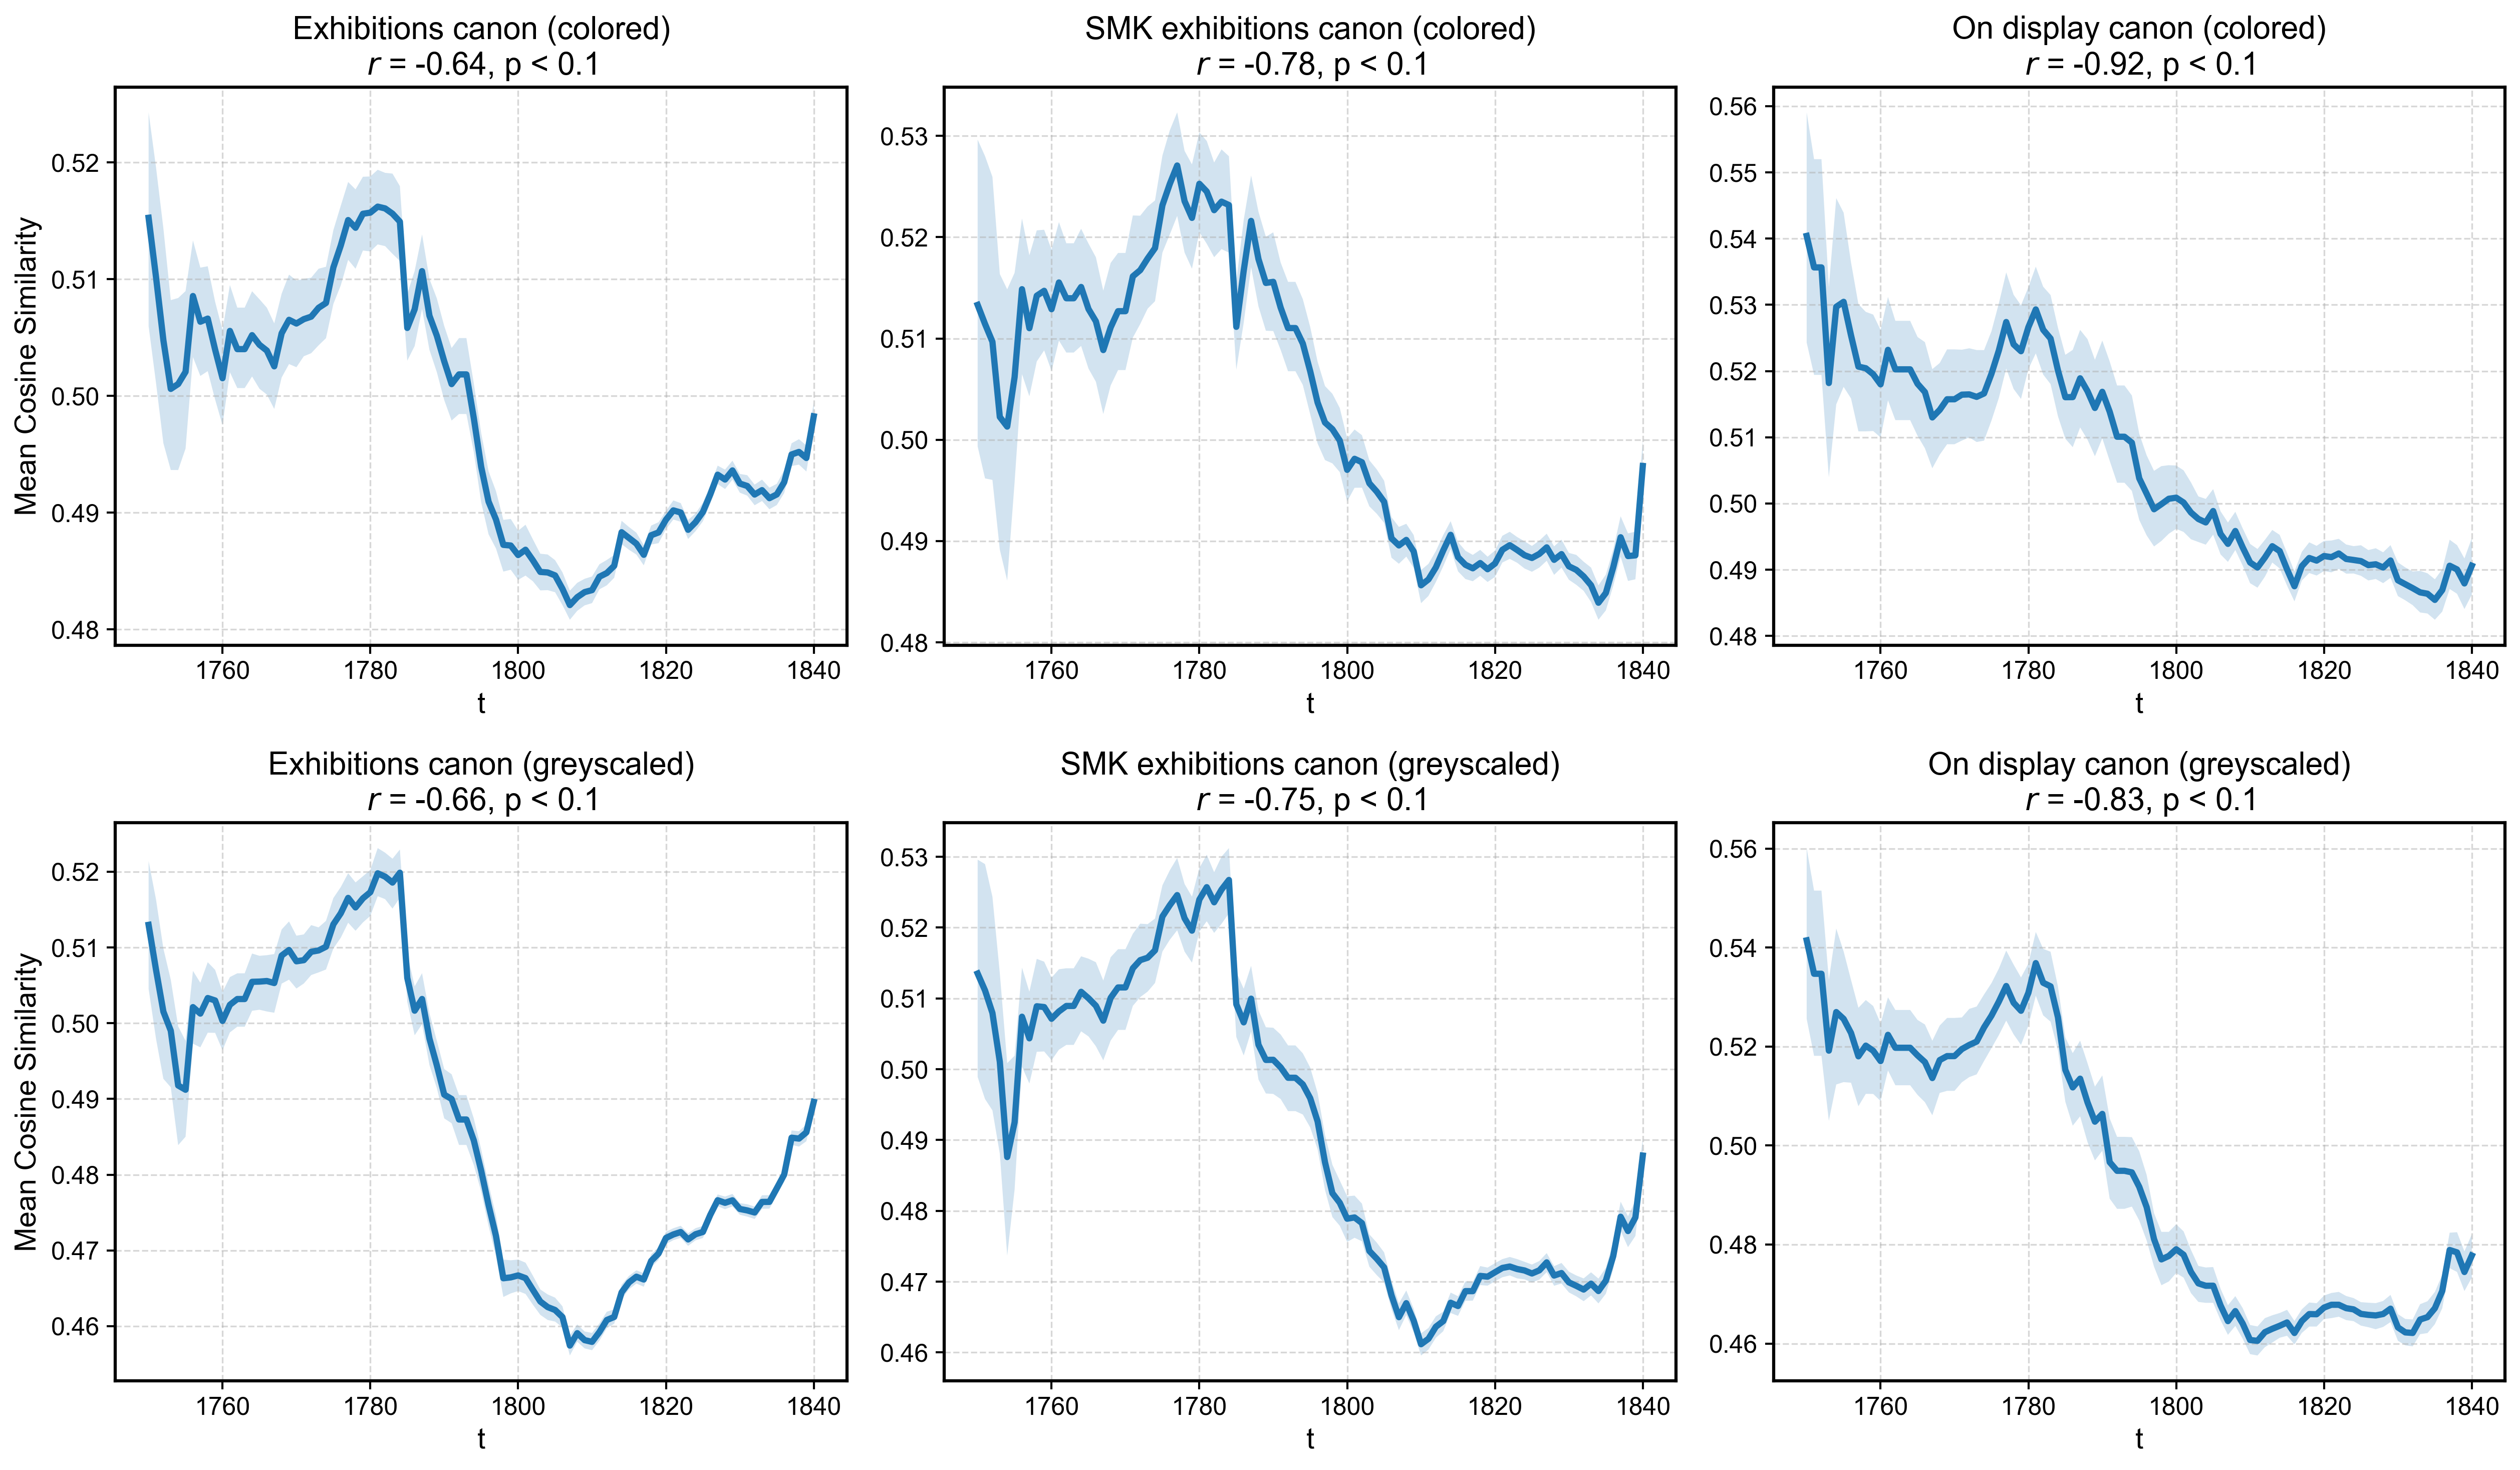

In [15]:
# canon

canon_cols = ['exb_canon', 'smk_exhibitions', 'on_display']
plot_grid(df = df,
           color_subset=color_subset, 
            canon_cols = canon_cols,
            w_size= 30, 
            cosim_to_plot='CANON_COSIM_MEAN', 
            title='', 
            savefig=False,
            filename=os.path.join('figs', f'intra_canon_w30.png'))

0      [0.9636350697984575, 0.963744166150515]
1       [0.963778271182115, 0.963881039782783]
2     [0.9640042140638344, 0.9642157468280175]
3      [0.9627075591148372, 0.962848951236758]
4     [0.9607302033701719, 0.9609400587207303]
                        ...                   
86    [0.9824875579193093, 0.9825401640417564]
87      [0.98156015852262, 0.9816153418551197]
88    [0.9818828715914388, 0.9819311930613529]
89     [0.982343786513849, 0.9823941168184285]
90    [0.9821354860492217, 0.9822203686969153]
Name: CANON_NONCANON_COSIM_CI, Length: 91, dtype: object


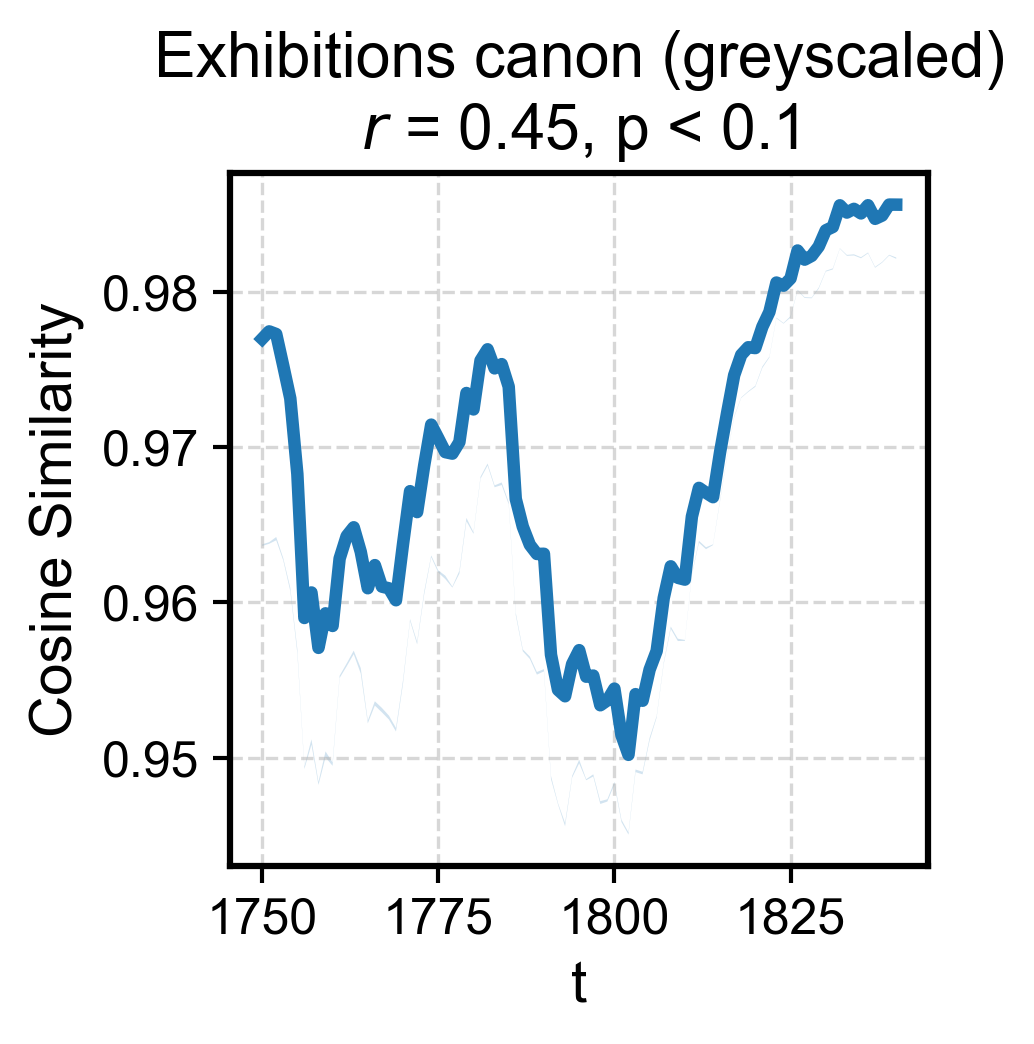

In [39]:
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
plot_diachronic_change(w_size = 30, 
                    df = df, 
                    canon_col = 'exb_canon', 
                    embedding_col = 'grey_embedding', 
                    cosim_to_plot = 'CANON_NONCANON_COSIM', 
                    ax = axs)

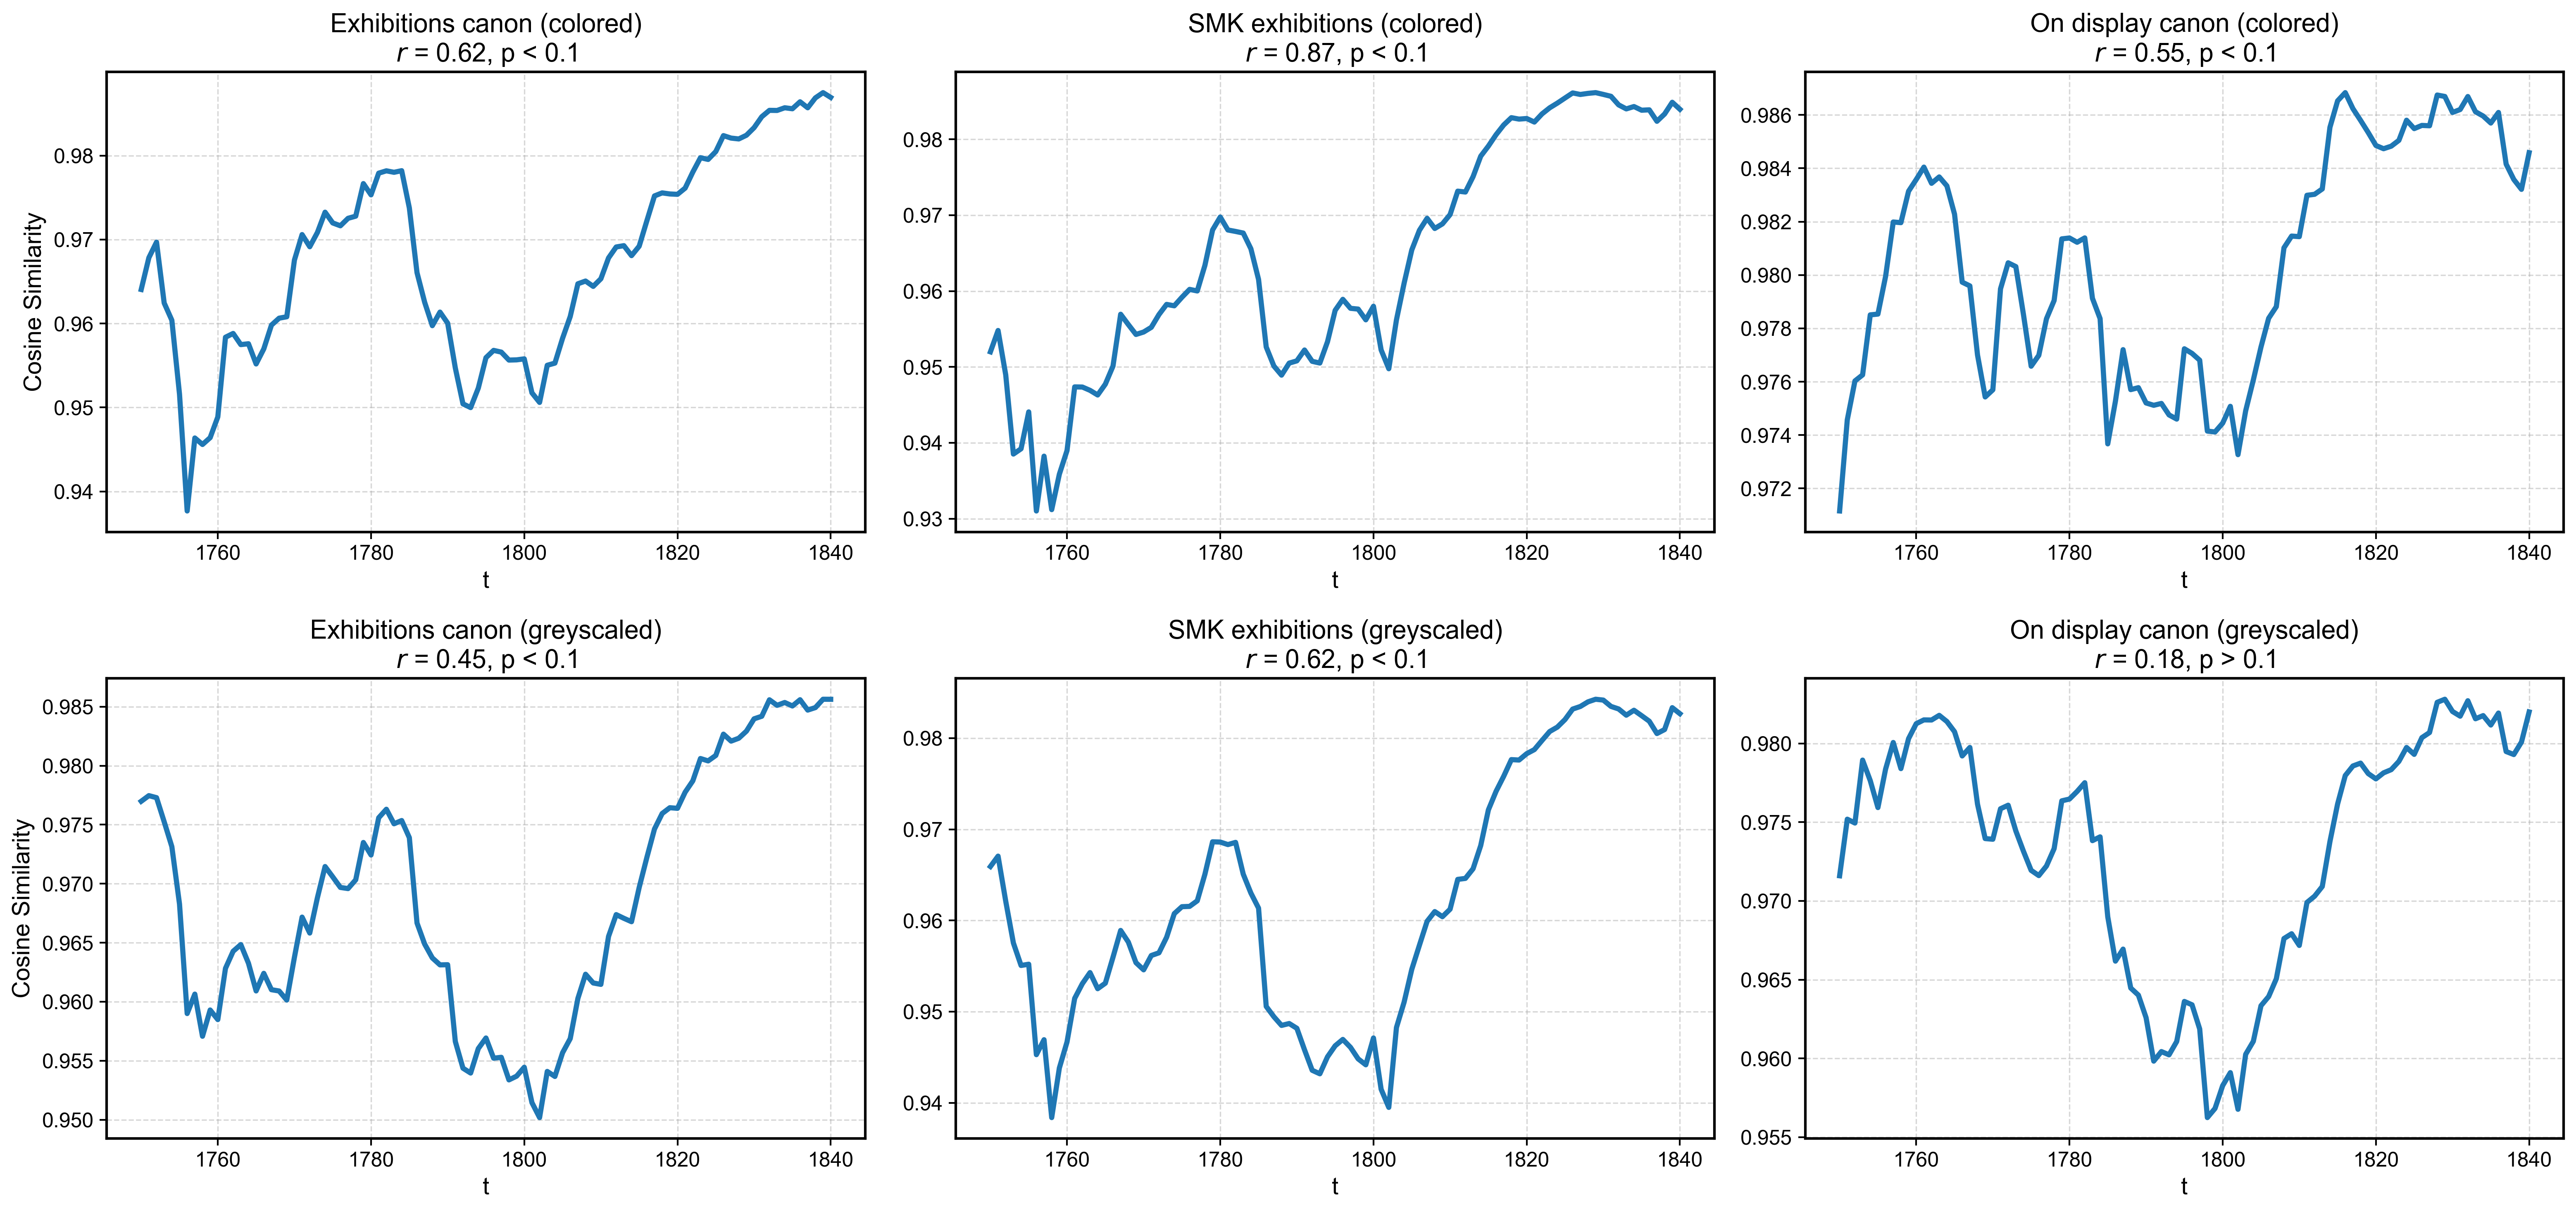

In [61]:
# inter

plot_grid(df = df, 
            color_subset = color_subset, 
            canon_cols = canon_cols,
        w_size= 30, 
            cosim_to_plot='CANON_NONCANON_COSIM', 
            title='',
            savefig=False,
            filename=os.path.join('figs', f'inter_w30.png'))

In [97]:
# pca 

def pca_binary(ax, df, embedding, canon_category, title):
    
    embeddings_array = np.array(df[embedding].to_list(), dtype=np.float32)
    
    color_mapping = {'other': '#129525', 'canon': '#75BCC6'}
    label_mapping = {'other': 'Non-canon', 'canon': 'Canon'}

    # to 2 dimensions
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(embeddings_array)
    df_pca = pd.DataFrame(pca_results, columns=["PCA1", "PCA2"])
    df_pca["canon"] = df[canon_category].values

    # Plot each category
    for category in df_pca["canon"].unique():
        subset = df_pca[df_pca["canon"] == category]

        #marker = markers_dict.get(category) 
        #alpha = alpha_dict.get(category)
        
        ax.scatter(
            subset["PCA1"],
            subset["PCA2"],
            color=color_mapping.get(category),
            label=label_mapping.get(category),
            alpha=0.6,
            edgecolor='black',
            s=110,
            marker='o' #marker
        )

    #for spine in ax.spines.values():
        #spine.set_linewidth(1.5)

    #for spine in ax.spines.values():
        #spine.set_visible(False)

    ax.set_title(title, fontsize=10)
    ax.set_xlabel("PCA1", fontsize=8)
    ax.set_ylabel("PCA2", fontsize=8)
    ax.tick_params(axis='both', labelsize=7)
    ax.grid(True, linestyle='--', alpha=0.2)

    legend_handles = [Patch(facecolor=color_mapping[key], label=label_mapping[key]) for key in color_mapping]
    ax.legend(handles=legend_handles, loc='upper right', fontsize=8)

    ax.axis("equal")

    # supress warnings 

    np.seterr(divide='ignore', invalid='ignore')

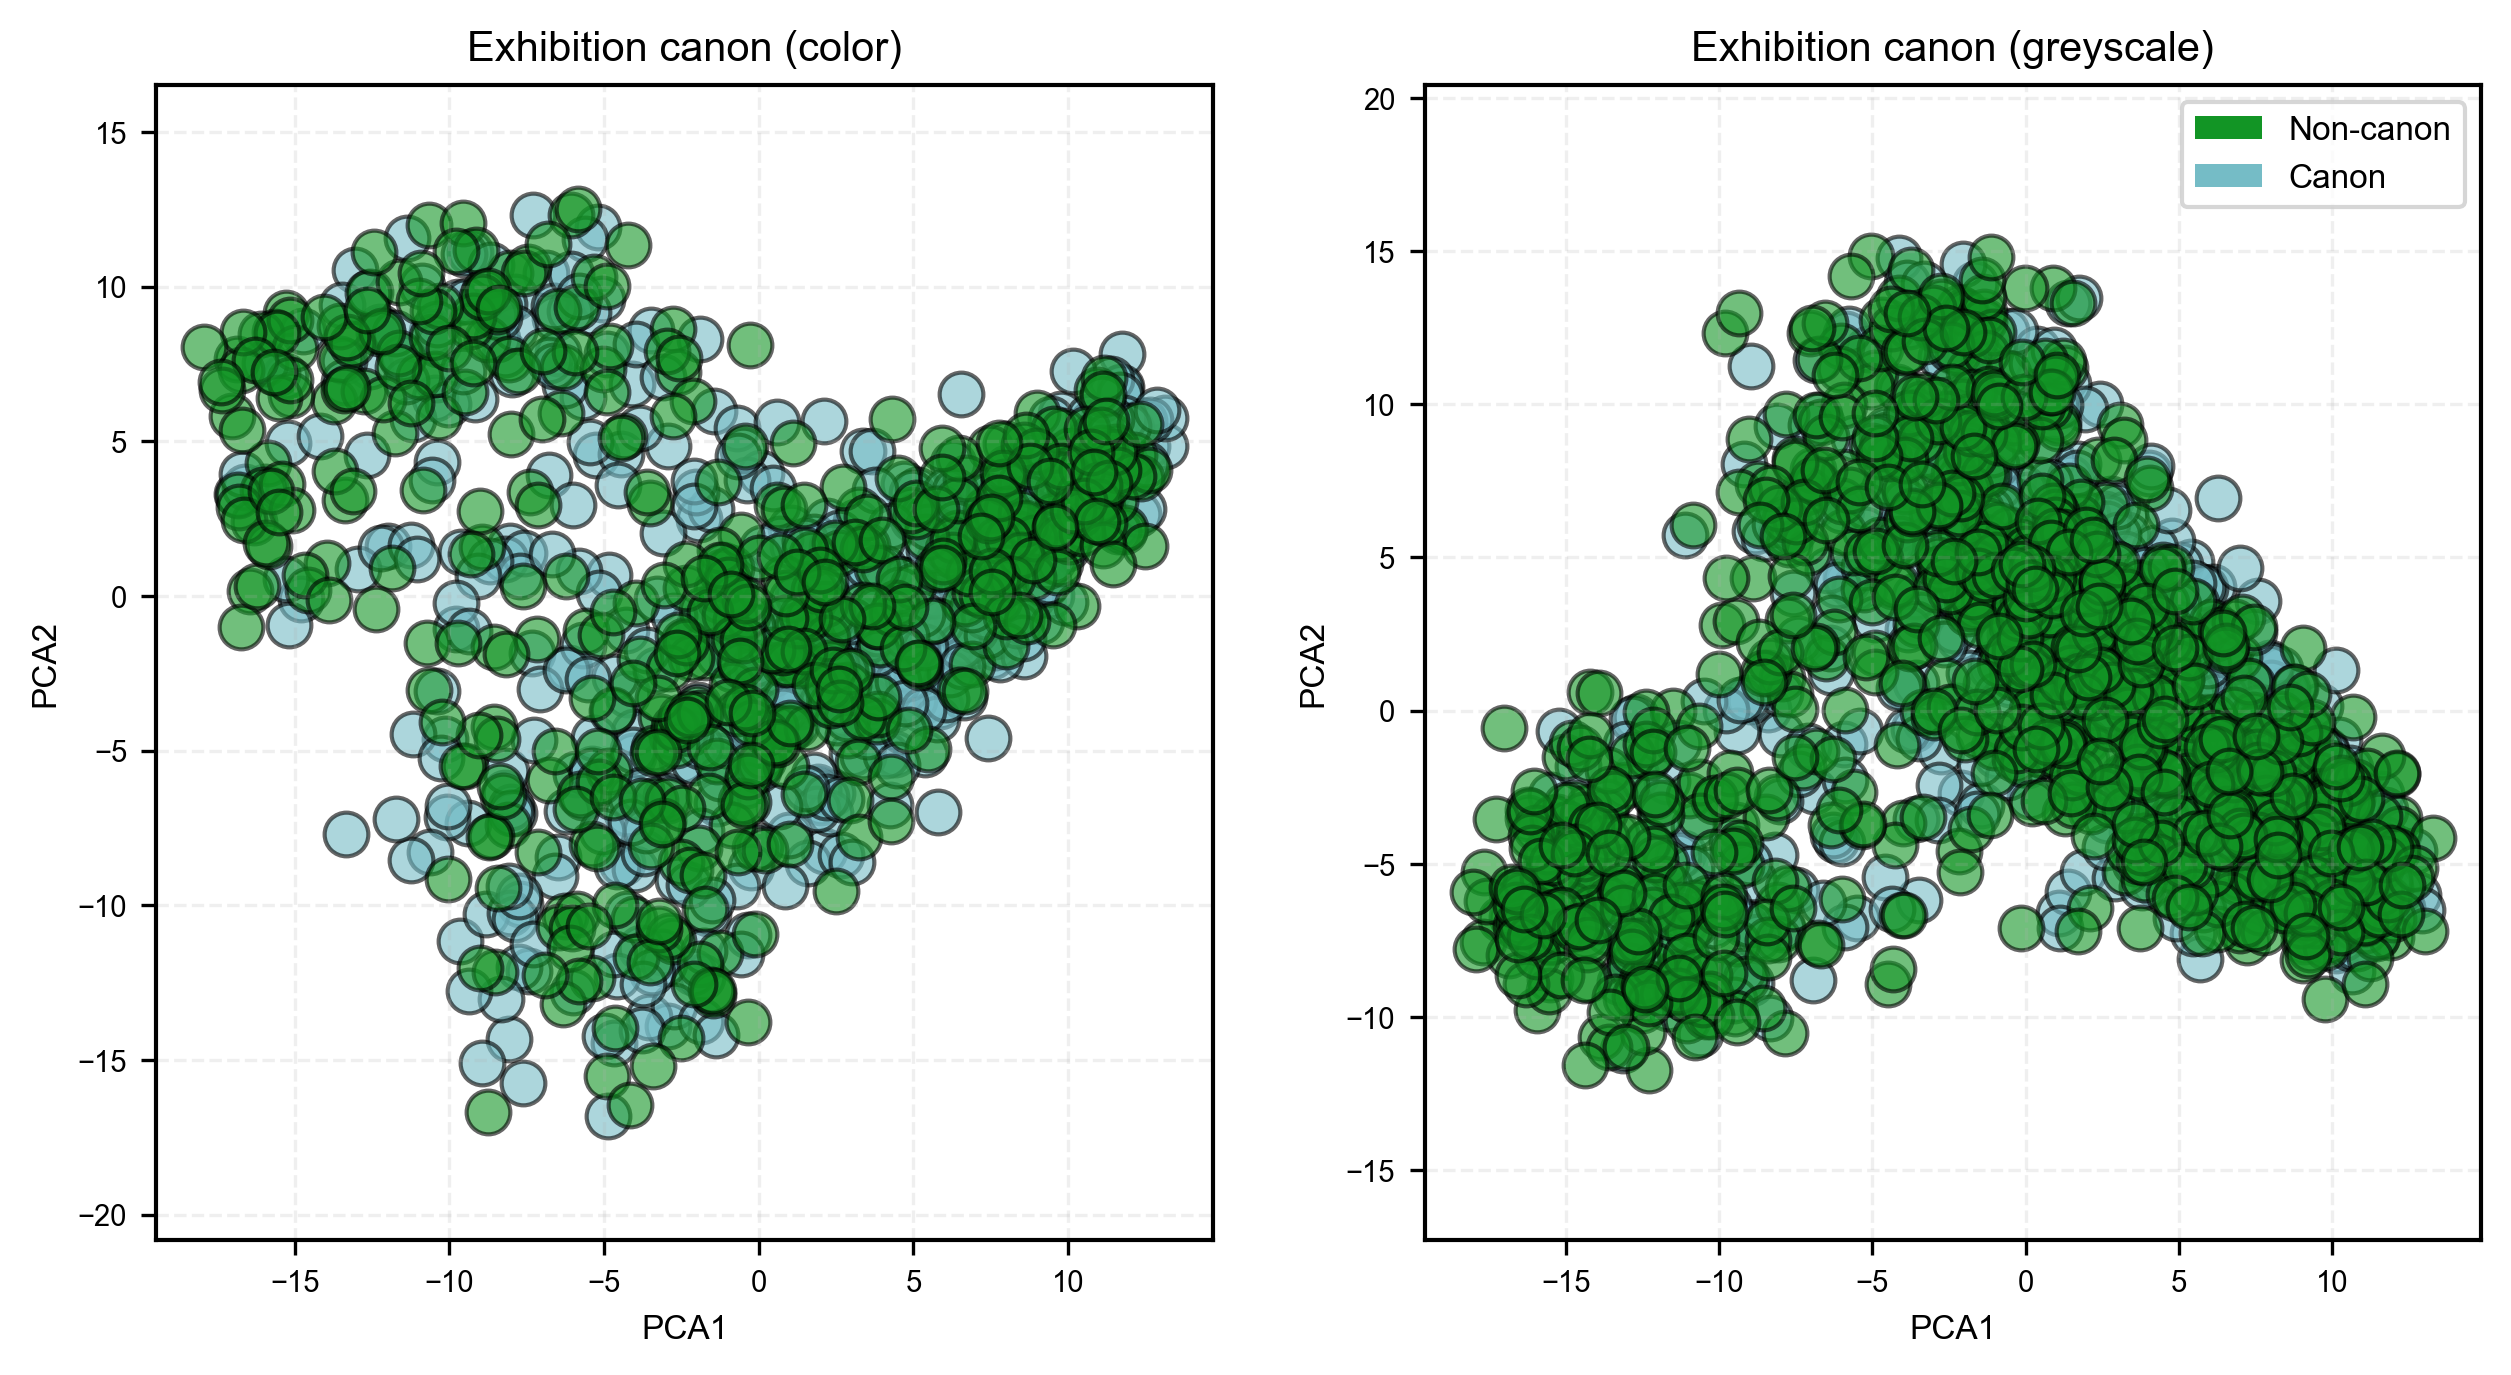

In [99]:
# plot pca_binary, greyscale and color embeddings
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

pca_binary(ax = axs[0], 
            df = color_subset, 
            embedding = 'embedding', 
            canon_category = 'exb_canon', 
            title = "Exhibition canon (color)")

axs[0].legend_.remove()

pca_binary(ax = axs[1], 
    df = df, 
    embedding = 'grey_embedding', 
    canon_category = 'exb_canon', 
    title = f"Exhibition canon (greyscale)")

In [46]:
df['first_nationality'] = df['nationality'].apply(lambda x: x[0])

In [48]:
df['first_nationality'].value_counts()

first_nationality
Dansk         1349
Tysk            78
Norsk           37
Fransk          21
Svensk          17
Italiensk       11
Hollandsk        4
Engelsk          3
Østrigsk         3
Schweizisk       3
Flamsk           2
Amerikansk       2
Russisk          1
Polsk            1
Tjekkisk         1
Britisk          1
Name: count, dtype: int64

In [77]:
len(df['exhibition_venues'].explode().unique())

148

In [ ]:
df['first_artist'].unique()

array(['Martinus Rørbye', 'Kristian Zahrtmann', 'Nicolai Abildgaard',
       'Jean Barbault', 'C.A. Jensen', 'Elisabeth Jerichau Baumann',
       'Jan ten Compe', 'Christen Købke', 'Wilhelm Bendz', 'Jens Juel',
       'Johan Thomas Lundbye', 'J.C. Dahl', 'P.C. Skovgaard',
       'Vilhelm Kyhn', 'Constantin Hansen', 'C.G. Pilo', 'Albert Küchler',
       'Emanuel Larsen', 'Emil Ditlev Bærentzen', 'C.W. Eckersberg',
       'Wilhelm Marstrand', 'A.W. Boesen', 'Jørgen V. Sonne',
       'Lorenz Frølich', 'Jørgen Roed', 'Heinrich Eddelien',
       'Frederik Vermehren', 'Christen Dalsgaard', 'C.A. Lorentzen',
       'F. Sødring', 'Thorald Læssøe', 'Dankvart Dreyer', 'J.L. Lund',
       'Christine Løvmand', 'Hermania Neergaard', 'Carl Neumann',
       'Andreas Herman Hunæus', 'J.V. Gertner', 'Ditlev Blunck',
       'Anton Raphael Mengs', 'Giovanni Domenico Tiepolo',
       'Batoni, Pompeo Girolamo', 'O.D. Ottesen', 'Samuel Mygind',
       'Christian David Gebauer', 'Louis Gurlitt', 'Julius Exne

In [76]:
unique_artists = df['exhibition_venues'].explode().unique()

# Convert to string and write to a text file
with open('unique_artists.txt', 'w', encoding='utf-8') as f:
    for artist in unique_artists:
        f.write(str(artist) + '\n')

In [65]:
hej = df.drop_duplicates(subset='first_artist').groupby('first_nationality', dropna=False)['first_artist'].count().sort_values(ascending=False)

In [73]:
df.query('start_year < 1800')

smk_id     period  start_year  \
5      KMS6557       1750        1750   
9      KMS3022       1753        1753   
10    KMSst223       1753        1753   
13     KMS1560  1798-1801        1799   
24     KMS8856       1752        1752   
...        ...        ...         ...   
1634  KMS1139e       1783        1783   
1636    KMS596  1785-1786        1785   
1644   KMS4155       1752        1752   
1647  KMS1139d       1782        1782   
1653   KMS8925  1788-1792        1790   

                                                  title        first_artist  \
5                Romersk kokkedreng, der sliber en kniv       Jean Barbault   
9                 Herresædet Marquette, set fra sydvest       Jan ten Compe   
10                Herresædet Marquette, set fra nordøst       Jan ten Compe   
13                            Gertrud Hage, f. Heitmann           Jens Juel   
24    Portræt af Elisabeth Marie Fabritius, født d'A...           C.G. Pilo   
...                                                 ...                 ...   
1634          Frederik III modtager enevoldsmagten 1660  Nicolai Abildgaard   
1636  Potuanernes andagt på festdagen for den ubegri...  Nicolai Abildgaard   
1644  Hofjuvelér Christopher Fabritius og hustru Gun...           Peder Als   
1647  Christian IV på "Trefoldigheden" i slaget på K...  Nicolai Abildgaard   
1653    Portræt af Kennett Dixon, der spiller badminton     William Beechey   

               all_artists  num_artists main_type all_types  \
5          [Jean Barbault]            1    Maleri  [Maleri]   
9          [Jan ten Compe]            1    Maleri  [Maleri]   
10         [Jan ten Compe]            1    Maleri  [Maleri]   
13             [Jens Juel]            1    Maleri  [Maleri]   
24             [C.G. Pilo]            1    Maleri  [Maleri]   
...                    ...          ...       ...       ...   
1634  [Nicolai Abildgaard]            1    Maleri  [Maleri]   
1636  [Nicolai Abildgaard]            1    Maleri  [Maleri]   
1644           [Peder Als]            1    Maleri  [Maleri]   
1647  [Nicolai Abildgaard]            1    Maleri  [Maleri]   
1653     [William Beechey]            1    Maleri  [Maleri]   

                                        image_thumbnail  ...  \
5     https://iip-thumb.smk.dk/iiif/jp2/zw12z8688_KM...  ...   
9     https://api.smk.dk/api/v1/thumbnail/5f4a507d-6...  ...   
10    https://api.smk.dk/api/v1/thumbnail/4acfc63f-a...  ...   
13    https://iip-thumb.smk.dk/iiif/jp2/tb09j948j_km...  ...   
24    https://iip-thumb.smk.dk/iiif/jp2/nc580q51v_km...  ...   
...                                                 ...  ...   
1634  https://iip-thumb.smk.dk/iiif/jp2/q811kn85p_KM...  ...   
1636  https://iip-thumb.smk.dk/iiif/jp2/dn39x487m_KM...  ...   
1644  https://iip-thumb.smk.dk/iiif/jp2/gb19f975p_KM...  ...   
1647  https://iip-thumb.smk.dk/iiif/jp2/0c483n915_KM...  ...   
1653  https://iip-thumb.smk.dk/iiif/jp2/rf55zc238_km...  ...   

                                  ex_years                    ex_distances  \
5                       [2010, 2004, 2013]                 [260, 254, 263]   
9                                     <NA>                            <NA>   
10                                    <NA>                            <NA>   
13    [2007, 2005, 1996, 2025, 2025, 2026]  [209, 207, 198, 227, 227, 228]   
24                                    <NA>                            <NA>   
...                                    ...                             ...   
1634              [2008, 2009, 2009, 2007]            [225, 226, 226, 224]   
1636        [2008, 2009, 2009, 2004, 2005]       [223, 224, 224, 219, 220]   
1644                                [2017]                           [265]   
1647                          [2007, 2002]                      [225, 220]   
1653                                  <NA>                            <NA>   

                             smk_distances dist_canon canon_idx  \
5                         [<NA>, 36,

In [78]:
embeddings = np.stack(df['grey_embedding'].values)

In [79]:
similarities = cosine_similarity(embeddings)
mean_cosim = similarities.mean()

In [80]:
mean_cosim

np.float64(0.4438921939800931)

In [81]:
similarities.max()

np.float64(1.0000000000000042)

In [83]:
similarities.min()

np.float64(0.09363585854291015)

In [86]:
df['on_display']

0       canon
1       other
2       other
3       other
4       canon
        ...  
1651    other
1652    other
1653    canon
1654    canon
1655    canon
Name: on_display, Length: 1656, dtype: object

In [87]:
# plot intra-group for all non-canon data

non_canon = []

for idx, row in df.iterrows():
    if (
        row['exb_canon'] == 'canon' or
        row['smk_exhibitions'] == 'canon' or
        row['on_display'] == 'canon'
    ):
        non_canon.append('canon')
    else:
        non_canon.append('other')

In [95]:
df['total_canons'] = non_canon

In [101]:
from src.analyses_utils import plot_diachronic_change

In [99]:
df['total_canons']

0       canon
1       canon
2       canon
3       canon
4       canon
        ...  
1651    canon
1652    canon
1653    canon
1654    canon
1655    canon
Name: total_canons, Length: 1656, dtype: object

Mean: 0.5243, 95% CI: [0.5170, 0.5315]
[np.float64(0.5170013018382393), np.float64(0.5314989080982159)]
Mean: 0.5155, 95% CI: [0.5118, 0.5193]
Mean: 0.5159, 95% CI: [0.5134, 0.5185]
Mean: 0.5185, 95% CI: [0.5113, 0.5257]
[np.float64(0.5112607596379086), np.float64(0.5257434221924505)]
Mean: 0.5144, 95% CI: [0.5110, 0.5179]
Mean: 0.5137, 95% CI: [0.5113, 0.5161]
Mean: 0.5130, 95% CI: [0.5064, 0.5204]
[np.float64(0.5064291827816232), np.float64(0.5204201940101413)]
Mean: 0.5110, 95% CI: [0.5071, 0.5144]
Mean: 0.5100, 95% CI: [0.5076, 0.5123]
Mean: 0.5048, 95% CI: [0.4987, 0.5112]
[np.float64(0.49871894882632695), np.float64(0.5112102283591348)]
Mean: 0.5049, 95% CI: [0.5018, 0.5082]
Mean: 0.5031, 95% CI: [0.5010, 0.5055]
Mean: 0.5000, 95% CI: [0.4937, 0.5065]
[np.float64(0.49367623599966937), np.float64(0.506496394772602)]
Mean: 0.5081, 95% CI: [0.5047, 0.5114]
Mean: 0.5038, 95% CI: [0.5016, 0.5059]
Mean: 0.4982, 95% CI: [0.4925, 0.5037]
[np.float64(0.49249340140875514), np.float64(0.503

KeyError: 'total_canons'

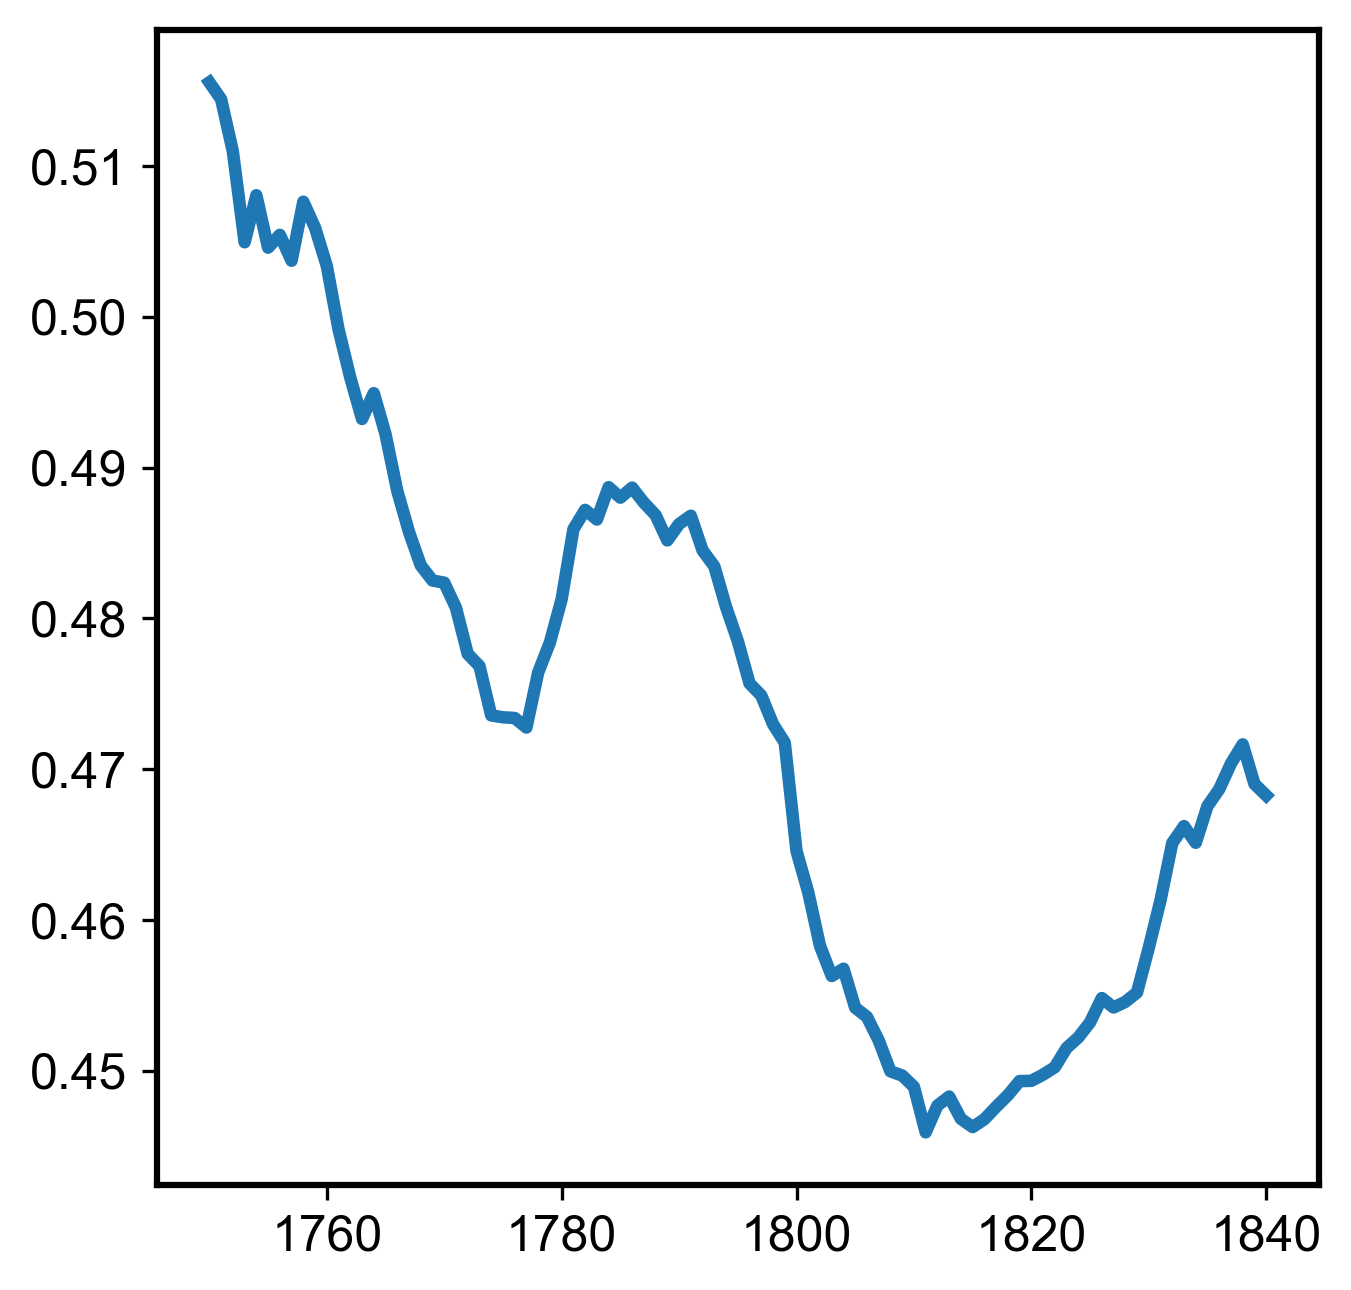

In [102]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))
plot_diachronic_change(w_size = 30, 
                    df = df, 
                    canon_col = 'total_canons', 
                    embedding_col = 'grey_embedding', 
                    cosim_to_plot = 'NONCANON_COSIM_MEAN', 
                    ax = axs)